In [13]:
from sqlalchemy import create_engine
import pandas as pd

engine = create_engine("sqlite:///cookbook.db")

recipe_df = pd.read_sql("SELECT * FROM recipe;", engine)
ingredient_df = pd.read_sql("SELECT * FROM ingredient;", engine)
link_df = pd.read_sql("SELECT * FROM recipe_ingredient;", engine)

In [14]:
print(recipe_df.shape, ingredient_df.shape, link_df.shape)
recipe_df.head()
ingredient_df.head()
link_df.head()

(555, 7) (2595, 2) (3701, 3)


,recipe_id,ingredient_id,quantity_id
0,0,0,0
1,0,1,1
2,0,2,2
3,0,3,3
4,0,4,4


In [15]:
recipe_ingredients = (
    link_df
    .merge(recipe_df, on="recipe_id")
    .merge(ingredient_df, on="ingredient_id")
    [["recipe_id", "title", "ingredient_name"]]
)

recipe_matrix = (
    recipe_ingredients
    .assign(value=1)
    .pivot_table(index="title", columns="ingredient_name", values="value", fill_value=0)
)

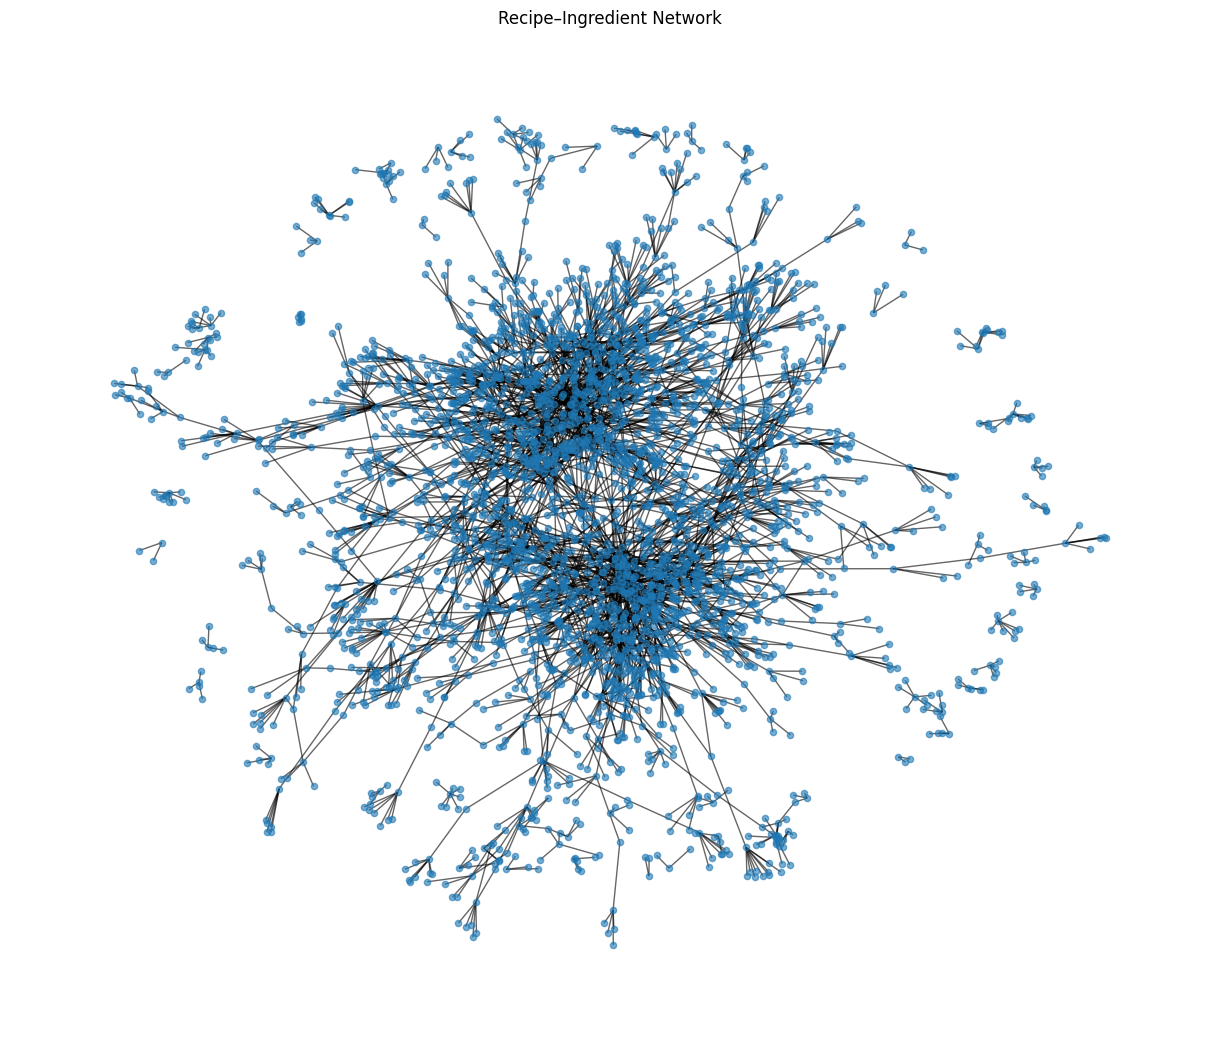

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

df = (link_df
      .merge(recipe_df, on="recipe_id")
      .merge(ingredient_df, on="ingredient_id")
      [["title", "ingredient_name"]])

# Create bipartite graph (recipes + ingredients)
G = nx.Graph()

# Add nodes
G.add_nodes_from(df["title"].unique(), bipartite="recipe")
G.add_nodes_from(df["ingredient_name"].unique(), bipartite="ingredient")

# Add edges between recipes and their ingredients
edges = list(df.itertuples(index=False, name=None))
G.add_edges_from(edges)

# Visualize (simplified for small data)
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.4)
nx.draw(G, pos, with_labels=False, node_size=20, alpha=0.6)
plt.title("Recipe–Ingredient Network")
plt.show()

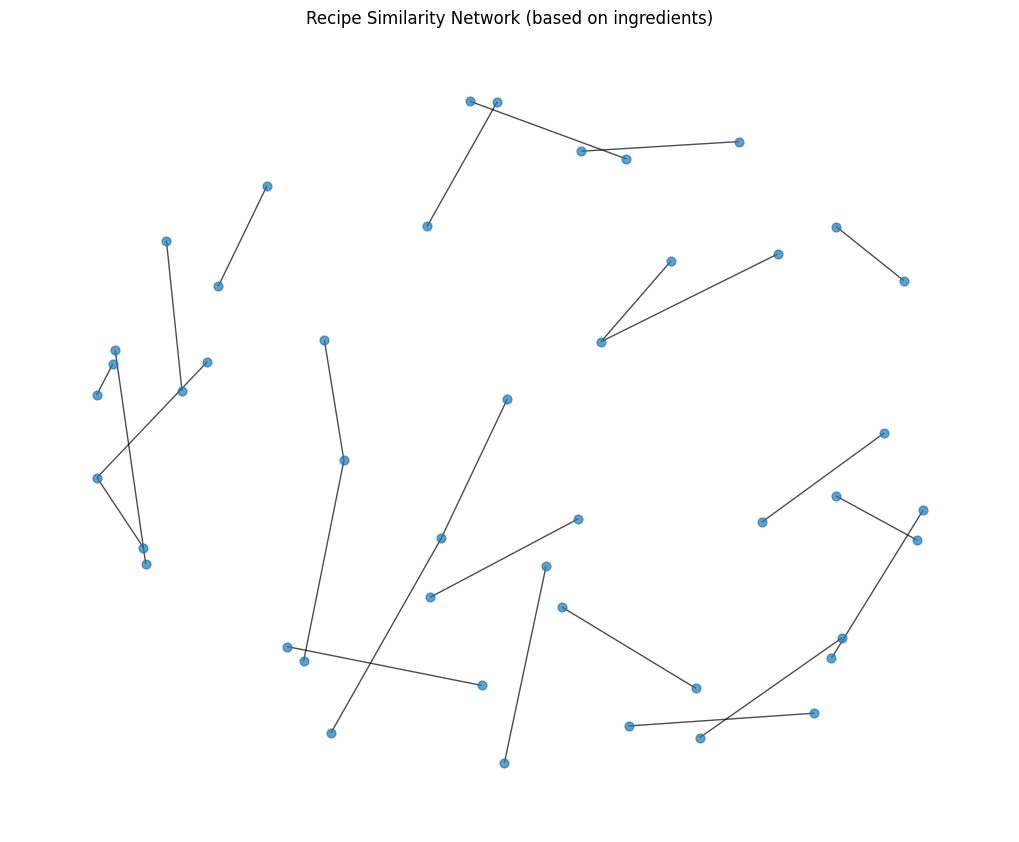

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Build recipe–ingredient matrix
recipe_matrix = (
    df.assign(value=1)
      .pivot_table(index="title", columns="ingredient_name", values="value", fill_value=0)
)

# Compute pairwise similarity
sim = cosine_similarity(recipe_matrix)
sim_df = pd.DataFrame(sim, index=recipe_matrix.index, columns=recipe_matrix.index)

# Create graph of recipes with strong similarity
G = nx.Graph()
for i, r1 in enumerate(sim_df.index):
    for j, r2 in enumerate(sim_df.index):
        if i < j and sim_df.iloc[i, j] > 0.4:  # threshold similarity
            G.add_edge(r1, r2, weight=sim_df.iloc[i, j])

plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=False, node_size=40, alpha=0.7)
plt.title("Recipe Similarity Network (based on ingredients)")
plt.show()

In [18]:
from pyvis.network import Network
from IPython.display import IFrame

# Build your G exactly as you already do...
# (G is an undirected NetworkX graph with edge attribute 'weight')

net = Network(height="750px", width="100%", notebook=True, bgcolor="#ffffff")

# Add nodes with labels + hover titles
for node in G.nodes():
    net.add_node(node, label=node, title=node)

# Add edges with hover showing similarity
for u, v, data in G.edges(data=True):
    w = float(data.get("weight", 1.0))
    net.add_edge(u, v, value=w, title=f"similarity: {w:.2f}")

# Nice physics layout
net.barnes_hut()

# Render and display in the notebook
net.show("recipe_similarity_network.html")
IFrame("recipe_similarity_network.html", width="100%", height=780)

recipe_similarity_network.html


In [19]:
# pip install pyvis

In [23]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import normalize
import difflib

# --- Load data ---
engine = create_engine("sqlite:///cookbook.db")
recipes = pd.read_sql("SELECT * FROM recipe;", engine)
ingredients = pd.read_sql("SELECT * FROM ingredient;", engine)
links = pd.read_sql("SELECT * FROM recipe_ingredient;", engine)

# Merge tables
df = (
    links.merge(recipes, on="recipe_id")
         .merge(ingredients, on="ingredient_id")
         [["title", "ingredient_name"]]
)

# --- Recipe–ingredient matrix ---
count_mat = (
    df.assign(val=1)
      .pivot_table(index="title", columns="ingredient_name", values="val", fill_value=0)
      .astype(float)
)

# --- TF-IDF weighting ---
tfidf = TfidfTransformer(norm=None, use_idf=True, smooth_idf=True)
tfidf_mat = tfidf.fit_transform(count_mat.values)
tfidf_mat = normalize(tfidf_mat)

# --- Cosine similarity ---
sim = cosine_similarity(tfidf_mat)
sim_df = pd.DataFrame(sim, index=count_mat.index, columns=count_mat.index)

def find_title(target, titles):
    """Fuzzy match a recipe title."""
    lower_map = {t.lower(): t for t in titles}
    if target.lower() in lower_map:
        return lower_map[target.lower()]
    matches = [t for t in titles if target.lower() in t.lower()]
    if matches:
        return matches[0]
    close = difflib.get_close_matches(target, titles, n=1, cutoff=0.6)
    return close[0] if close else None

def top_similar_recipes_with_shared(target_title, k=4):
    """Return top-k similar recipes and list shared ingredients."""
    resolved = find_title(target_title, count_mat.index)
    if resolved is None:
        raise ValueError(f"Recipe not found: {target_title}")

    # Get boolean presence of ingredients
    target_ings = count_mat.loc[resolved] > 0

    results = []
    for other in count_mat.index:
        if other == resolved:
            continue
        # Identify shared ingredients
        other_ings = count_mat.loc[other] > 0
        shared = count_mat.columns[target_ings & other_ings].tolist()
        if not shared:
            continue
        sim_score = sim_df.loc[resolved, other]
        results.append({
            "recipe": other,
            "similarity": round(sim_score, 3),
            "shared_count": len(shared),
            "shared_ingredients": shared
        })

    # Sort by similarity, then number of shared ingredients
    results_df = pd.DataFrame(results).sort_values(
        ["similarity", "shared_count"], ascending=False
    ).head(k)

    return results_df.reset_index(drop=True)

# --- Example ---
top_similar_recipes_with_shared("Beefless Burritos", k=4)

,recipe,similarity,shared_count,shared_ingredients
0,Beef-less Tacos,0.846,7,"[TJ's Beef-less Ground Beef, TJ's Iceberg Lett..."
1,Sheet Pan Fajitas,0.170,2,"[TJ's Olive Oil, TJ's Tortillas]"
2,Cheeseburger Pizza,0.109,1,[TJ's Mild Shredded Cheddar Cheese]
3,Creamed Greens,0.082,1,[TJ's Olive Oil]


In [24]:
similar_to_pot = top_similar_recipes_with_shared("smashed potatoes", k=4)
similar_to_pot

,recipe,similarity,shared_count,shared_ingredients
0,21 Seasoning Salute Vinaigrette,0.434,3,"[TJ’s Extra Virgin Olive Oil, TJ’s Ground Blac..."
1,Seared Salmon & Quick-Pickled Cucumbers,0.277,3,"[TJ’s Extra Virgin Olive Oil, TJ’s Ground Blac..."
2,"Blistered Tomato, Spinach, & Feta Frittata",0.252,2,"[TJ’s Extra Virgin Olive Oil, TJ’s Ground Blac..."
3,Creamy Dreamy Hummus with Roasted Baby Broccoli,0.218,2,"[TJ’s Extra Virgin Olive Oil, TJ’s Sea Salt]"


In [ ]:
# concern: main pantry ingredients being used as kkn

In [2]:
import pandas as pd
from sqlalchemy import create_engine

# Connect to your SQLite database
engine = create_engine("sqlite:///cookbook.db")

# Load the link and ingredient tables
links = pd.read_sql("SELECT * FROM recipe_ingredient;", engine)
ingredients = pd.read_sql("SELECT * FROM ingredient;", engine)

# Merge so each row = (recipe_id, ingredient_name)
merged = links.merge(ingredients, on="ingredient_id")

# Count how many unique recipes each ingredient appears in
ingredient_counts = (
    merged.groupby("ingredient_name")["recipe_id"]
    .nunique()  # ensures we only count each recipe once per ingredient
    .reset_index(name="recipe_count")
    .sort_values("recipe_count", ascending=False)
)

# Display top 20
ingredient_counts.head(50)

,ingredient_name,recipe_count
1200,TJ's Sea Salt,44
2277,TJ’s Sea Salt,37
846,TJ's Olive Oil,27
2287,"TJ’s Sea Salt, to taste",25
2015,TJ’s Olive Oil,24
2592,water,21
2044,TJ’s Organic Cane Sugar,17
327,TJ's Canola Oil Spray,16
1730,TJ’s Extra Virgin Olive Oil,16
505,TJ's Extra Virgin Olive Oil,15


In [ ]:
common_items = [
    "TJ's Salt & Pepper",
    "TJ’s Olive Oil",
    "water"

]